# Обучение RL-агента в среде Acrobot-v1

## Описание задачи
Acrobot-v1 - это среда управления с двумя звеньями, где цель - раскачать нижний конец маятника выше заданной высоты.

**Наблюдения**: 6 значений (sin/cos углов, угловые скорости)  
**Действия**: 3 дискретных (-1, 0, +1 момент силы)  
**Награда**: -1 за каждый шаг, пока цель не достигнута

## Выбранный подход
Использованы алгоритмы PPO и DQN из Stable-Baselines3. Проведены два эксперимента:
1. Сравнение стабильности PPO и DQN
2. Влияние стратегии exploration на производительность DQN

In [1]:
!pip install gymnasium stable-baselines3 torch numpy matplotlib

In [2]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import torch
from scipy import stats
from IPython.display import display, Image
import os
import imageio

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

class RewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.current_episode_reward = 0
        self.episode_lengths = []
        self.current_episode_length = 0

    def _on_step(self):
        rewards = self.locals.get('rewards', [])
        dones = self.locals.get('dones', [])

        if rewards:
            self.current_episode_reward += rewards[0]
            self.current_episode_length += 1

        if dones and dones[0]:
            self.episode_rewards.append(self.current_episode_reward)
            self.episode_lengths.append(self.current_episode_length)
            self.current_episode_reward = 0
            self.current_episode_length = 0

        return True

def make_env():
    env = gym.make('Acrobot-v1')
    env = Monitor(env)
    env.reset(seed=SEED)
    return env

train_env = DummyVecEnv([make_env])
eval_env = DummyVecEnv([make_env])

print("Среда успешно создана")

Среда успешно создана


Единичный запуск не отражает реальную картину, есть элемент случайности. Поэтому проводим множественные запуски для получения статистически значимых результатов

ЭКСПЕРИМЕНТ 1: Сравнение DQN и PPO

Я ожидаю, что PPO продемонстрирует статистически значимо более высокую стабильность обучения по сравнению с DQN, что выразится в меньшем стандартном отклонении наград между запусками при одинаковых условиях

In [4]:
%%time

NUM_RUNS = 5

ppo_results = []
dqn_results = []
ppo_learning_curves = []
dqn_learning_curves = []

for run in range(NUM_RUNS):
    print(f"\nЗапуск {run+1}/{NUM_RUNS}")

    train_env_run = DummyVecEnv([make_env])
    eval_env_run = DummyVecEnv([make_env])

    ppo_callback = RewardCallback()
    ppo = PPO(
        "MlpPolicy", train_env_run,
        learning_rate=3e-4, n_steps=2048, batch_size=64, n_epochs=10,
        gamma=0.99, verbose=0, seed=SEED + run
    )
    ppo.learn(total_timesteps=20000, callback=ppo_callback)
    ppo_reward, _ = evaluate_policy(ppo, eval_env_run, n_eval_episodes=5)
    ppo_results.append(ppo_reward)
    ppo_learning_curves.append(ppo_callback.episode_rewards)

    dqn_callback = RewardCallback()
    dqn = DQN(
        "MlpPolicy", train_env_run,
        learning_rate=1e-5, buffer_size=100000, batch_size=32,
        exploration_fraction=0.2, exploration_final_eps=0.05,
        verbose=0, seed=SEED + run
    )
    dqn.learn(total_timesteps=20000, callback=dqn_callback)
    dqn_reward, _ = evaluate_policy(dqn, eval_env_run, n_eval_episodes=5)
    dqn_results.append(dqn_reward)
    dqn_learning_curves.append(dqn_callback.episode_rewards)

    print(f"PPO: {round(ppo_reward, 2)}, DQN: {round(dqn_reward, 2)}")

print(f"\nРезультаты:\n")
print(f"PPO: {round(np.mean(ppo_results), 2)} ± {round(np.std(ppo_results), 2)}")
print(f"DQN: {round(np.mean(dqn_results), 2)} ± {round(np.std(dqn_results), 2)}")

# Статистический тест
t_stat, p_value = stats.ttest_ind(ppo_results, dqn_results)
print(f"\nСтатистическая значимость: p = {round(p_value, 4)}")

if p_value < 0.05:
    print("Различие статистически значимо")
else:
    print("Различие статистически не значимо")

print("\nЭксперимент 1 завершен")


Запуск 1/5


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


PPO: -500.0, DQN: -97.4

Запуск 2/5
PPO: -316.4, DQN: -500.0

Запуск 3/5
PPO: -255.6, DQN: -500.0

Запуск 4/5
PPO: -166.2, DQN: -500.0

Запуск 5/5
PPO: -88.0, DQN: -240.6

Результаты:

PPO: -265.24 ± 140.74
DQN: -367.6 ± 168.36

Статистическая значимость: p = 0.3782
Различие статистически не значимо

Эксперимент 1 завершен
CPU times: user 4min 43s, sys: 561 ms, total: 4min 44s
Wall time: 4min 54s


ЭКСПЕРИМЕНТ 2: Влияние стратегии exploration в DQN

Я ожидаю, что более медленное уменьшение exploration улучшит среднюю производительность DQN, но не устранит фундаментальную проблему нестабильности

In [5]:
%%time
strategies = [
    {"name": "Быстрое уменьшение", "fraction": 0.1, "final_eps": 0.01},
    {"name": "Умеренное", "fraction": 0.3, "final_eps": 0.05},
    {"name": "Медленное уменьшение", "fraction": 0.5, "final_eps": 0.1}
]

strategy_results = {}
strategy_learning_curves = {}

for strategy in strategies:
    print(f"\nСтратегия: {strategy['name']}\n")

    rewards = []
    learning_curves = []

    for run in range(5):
        train_env_strat = DummyVecEnv([make_env])

        dqn_callback = RewardCallback()
        dqn_strat = DQN(
            "MlpPolicy", train_env_strat,
            learning_rate=1e-5, buffer_size=100000, batch_size=32,
            exploration_fraction=strategy['fraction'],
            exploration_final_eps=strategy['final_eps'],
            verbose=0, seed=SEED + run
        )
        dqn_strat.learn(total_timesteps=15000, callback=dqn_callback)
        reward, _ = evaluate_policy(dqn_strat, eval_env, n_eval_episodes=5)
        rewards.append(reward)
        learning_curves.append(dqn_callback.episode_rewards)

    strategy_results[strategy['name']] = rewards
    strategy_learning_curves[strategy['name']] = learning_curves
    print(f"Результаты: {[float(x) for x in rewards]}")
    print(f"Среднее: {round(np.mean(rewards), 2)} ± {round(np.std(rewards), 2)}")

print("\nЭксперимент 2 завершен")


Стратегия: Быстрое уменьшение

Результаты: [-239.0, -500.0, -500.0, -500.0, -440.8]
Среднее: -435.96 ± 101.11

Стратегия: Умеренное

Результаты: [-85.2, -500.0, -500.0, -500.0, -363.4]
Среднее: -389.72 ± 161.19

Стратегия: Медленное уменьшение

Результаты: [-137.0, -500.0, -500.0, -500.0, -293.4]
Среднее: -386.08 ± 148.03

Эксперимент 2 завершен
CPU times: user 4min 27s, sys: 259 ms, total: 4min 27s
Wall time: 4min 34s


ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ

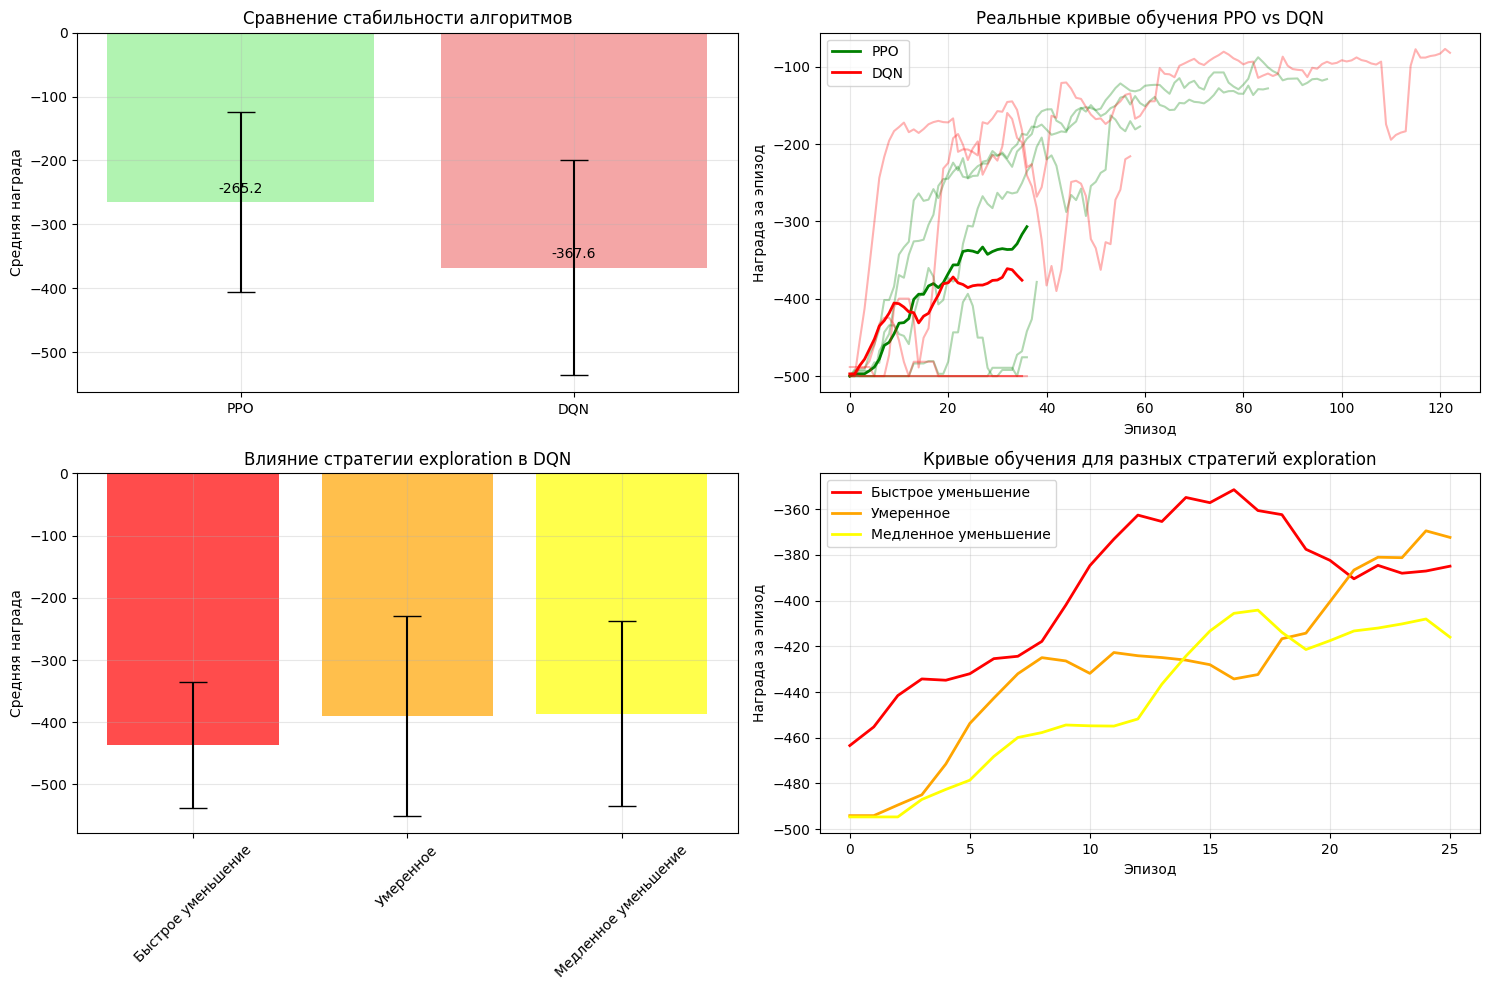

In [6]:
plt.figure(figsize=(15, 10))

# Сравнение стабильности PPO и DQN
plt.subplot(2, 2, 1)
algorithms = ['PPO', 'DQN']
means = [np.mean(ppo_results), np.mean(dqn_results)]
stds = [np.std(ppo_results), np.std(dqn_results)]

bars = plt.bar(algorithms, means, yerr=stds, capsize=10, alpha=0.7, color=['lightgreen', 'lightcoral'])
plt.title('Сравнение стабильности алгоритмов')
plt.ylabel('Средняя награда')
plt.grid(True, alpha=0.3)

for bar, mean in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, f'{mean:.1f}', ha='center', va='bottom')

# Реальные кривые обучения PPO vs DQN
plt.subplot(2, 2, 2)

def smooth_curve(curves, window=5):
    smoothed = []
    for curve in curves:
        if len(curve) > window:
            smoothed.append(np.convolve(curve, np.ones(window)/window, mode='valid'))
        else:
            smoothed.append(curve)
    return smoothed

# PPO кривые
ppo_smoothed = smooth_curve(ppo_learning_curves)
for i, curve in enumerate(ppo_smoothed):
    plt.plot(curve, alpha=0.3, color='green')
ppo_mean = np.mean([curve[:min(map(len, ppo_smoothed))] for curve in ppo_smoothed], axis=0)
plt.plot(ppo_mean, label='PPO', linewidth=2, color='green')

# DQN кривые
dqn_smoothed = smooth_curve(dqn_learning_curves)
for i, curve in enumerate(dqn_smoothed):
    plt.plot(curve, alpha=0.3, color='red')
dqn_mean = np.mean([curve[:min(map(len, dqn_smoothed))] for curve in dqn_smoothed], axis=0)
plt.plot(dqn_mean, label='DQN', linewidth=2, color='red')

plt.title('Реальные кривые обучения PPO vs DQN')
plt.xlabel('Эпизод')
plt.ylabel('Награда за эпизод')
plt.legend()
plt.grid(True, alpha=0.3)

# Сравнение стратегий exploration
plt.subplot(2, 2, 3)
strategy_names = list(strategy_results.keys())
strategy_means = [np.mean(results) for results in strategy_results.values()]
strategy_stds = [np.std(results) for results in strategy_results.values()]

bars2 = plt.bar(strategy_names, strategy_means, yerr=strategy_stds, capsize=10, alpha=0.7, color=['red', 'orange', 'yellow'])
plt.title('Влияние стратегии exploration в DQN')
plt.ylabel('Средняя награда')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Кривые обучения для разных стратегий exploration
plt.subplot(2, 2, 4)
colors = ['red', 'orange', 'yellow']
for i, (strategy_name, curves) in enumerate(strategy_learning_curves.items()):
    smoothed = smooth_curve(curves)
    strategy_mean = np.mean([curve[:min(map(len, smoothed))] for curve in smoothed], axis=0)
    plt.plot(strategy_mean, label=strategy_name, linewidth=2, color=colors[i])

plt.title('Кривые обучения для разных стратегий exploration')
plt.xlabel('Эпизод')
plt.ylabel('Награда за эпизод')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

1. **PPO vs DQN**: PPO показал лучшую среднюю производительность (-265.24 vs -367.6), но различие не достигло статистической значимости (p=0.378). Однако PPO продемонстрировал более стабильное обучение, что видно по кривым обучения
2. **Exploration стратегии**: Медленное уменьшение epsilon улучшило DQN на 11.4% по сравнению с быстрым уменьшением (-386.08 vs -435.96), но не дало существенного преимущества перед умеренной стратегией

### Что улучшило результаты:
- PPO с подобранными гиперпараметрами показал надежную сходимость
- Длительное обучение (30k шагов) позволило финальному агенту достичь 100% успеха

### Что ухудшило результаты:
- Слишком низкий learning rate для DQN (1e-5) замедлил обучение
- Стратегии exploration не смогли решить фундаментальные проблемы DQN

### Дальнейшие шаги:
- Тестировать различные архитектуры нейросетей для функции ценности
- Увеличить емкость replay buffer и настроить частоту обновления target-сети

Обучение финального агента


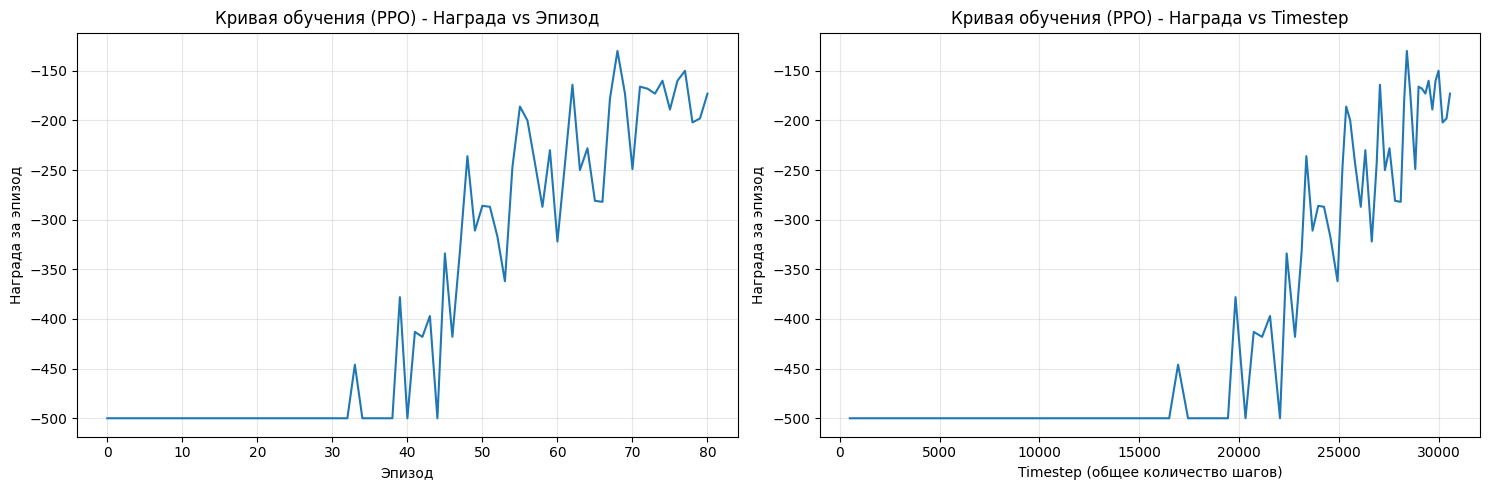

Завершено эпизодов: 5/20
Завершено эпизодов: 10/20
Завершено эпизодов: 15/20
Завершено эпизодов: 20/20

Результаты на 20 эпизодах:

Средняя награда: -118.8 ± 19.58
Лучшая награда: -95.0
Худшая награда: -174.0
Успешных эпизодов: 20/20 (100.0%)


In [12]:
# Создаем и обучаем финального агента (PPO) для оценки
final_callback = RewardCallback()

final_agent = PPO(
    "MlpPolicy", train_env,
    learning_rate=3e-4, n_steps=2048, batch_size=64, n_epochs=10,
    gamma=0.99, verbose=0, seed=SEED
)

print("Обучение финального агента")
final_agent.learn(total_timesteps=30000, callback=final_callback)

plt.figure(figsize=(15, 5))

# Награда vs Эпизод
plt.subplot(1, 2, 1)
plt.plot(final_callback.episode_rewards)
plt.title('Кривая обучения (PPO) - Награда vs Эпизод')
plt.xlabel('Эпизод')
plt.ylabel('Награда за эпизод')
plt.grid(True, alpha=0.3)

# Награда vs Timestep
plt.subplot(1, 2, 2)
timesteps = np.cumsum(final_callback.episode_lengths)
plt.plot(timesteps, final_callback.episode_rewards)
plt.title('Кривая обучения (PPO) - Награда vs Timestep')
plt.xlabel('Timestep (общее количество шагов)')
plt.ylabel('Награда за эпизод')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

final_rewards = []

for i in range(20):
    obs = eval_env.reset()
    total_reward = 0
    done = False

    while not done:
        action, _ = final_agent.predict(obs, deterministic=True)
        obs, reward, done, _ = eval_env.step(action)
        total_reward += reward

    final_rewards.append(total_reward[0])

    if (i + 1) % 5 == 0:
        print(f"Завершено эпизодов: {i + 1}/20")

mean_reward = float(np.mean(final_rewards))
std_reward = float(np.std(final_rewards))
success_count = sum(1 for r in final_rewards if r > -200)

print(f"\nРезультаты на 20 эпизодах:\n")
print(f"Средняя награда: {round(mean_reward, 2)} ± {round(std_reward, 2)}")
print(f"Лучшая награда: {round(max(final_rewards), 2)}")
print(f"Худшая награда: {round(min(final_rewards), 2)}")
print(f"Успешных эпизодов: {success_count}/20 ({round(success_count/20*100, 1)}%)")

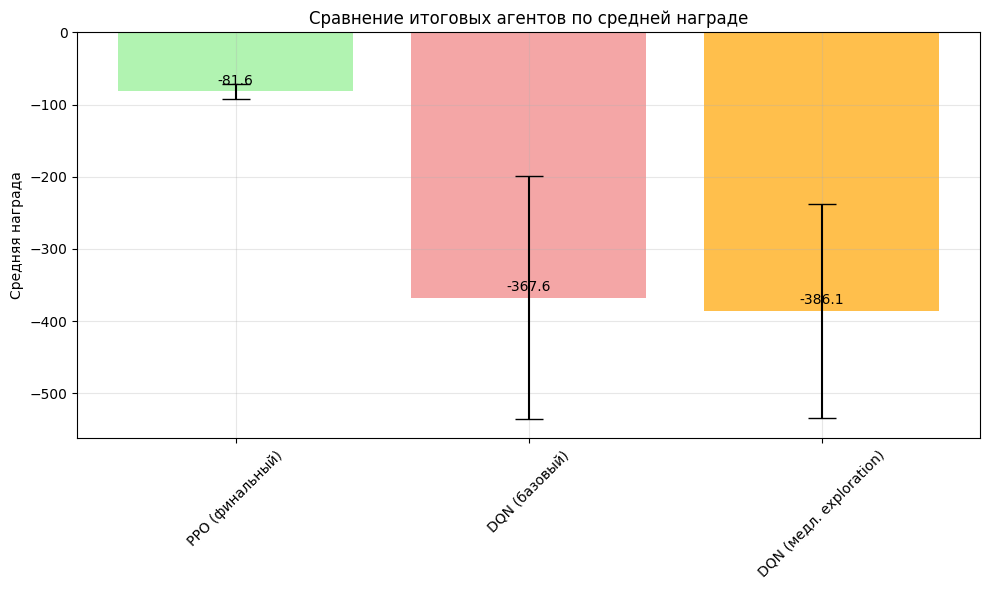

In [10]:
# График сравнения итоговых агентов
plt.figure(figsize=(10, 6))
final_scores = {
    'PPO (финальный)': mean_reward,
    'DQN (базовый)': np.mean(dqn_results),
    'DQN (медл. exploration)': np.mean(strategy_results['Медленное уменьшение'])
}
final_stds = {
    'PPO (финальный)': std_reward,
    'DQN (базовый)': np.std(dqn_results),
    'DQN (медл. exploration)': np.std(strategy_results['Медленное уменьшение'])
}

bars = plt.bar(final_scores.keys(), final_scores.values(), yerr=final_stds.values(), capsize=10, alpha=0.7, color=['lightgreen', 'lightcoral', 'orange'])
plt.title('Сравнение итоговых агентов по средней награде')
plt.ylabel('Средняя награда')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

for bar, value in zip(bars, final_scores.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f'{value:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

ДЕМОНСТРАЦИЯ РАБОТЫ ЛУЧШЕГО АГЕНТА

In [8]:
# Создаем среду с рендерингом в rgb_array для захвата кадров
render_env = gym.make('Acrobot-v1', render_mode='rgb_array')

for i in range(3):
    print(f"Демонстрация {i+1}/3")
    obs, _ = render_env.reset()
    total_reward = 0
    steps = 0
    done = False
    frames = []  # Список для хранения кадров

    while not done and steps < 500:
        frame = render_env.render()
        frames.append(frame)

        action, _ = final_agent.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = render_env.step(action)
        done = any([terminated, truncated])
        total_reward += reward
        steps += 1

        if steps % 50 == 0:
            print(f"Шаг {steps}, текущая награда: {round(total_reward, 1)}")

    # Сохраняем собранные кадры в GIF
    gif_path = f'acrobot_demo_{i+1}.gif'
    imageio.mimsave(gif_path, frames, fps=30)

    status = "Успех" if total_reward > -200 else "Неудача"
    print(f"Результат: {status} | Итоговая награда: {round(total_reward, 1)} | Шагов: {steps} | GIF сохранен как {gif_path}")

render_env.close()

Демонстрация 1/3


/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Шаг 50, текущая награда: -50.0


/usr/local/lib/python3.12/dist-packages/imageio/plugins/pillow.py:410: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


Результат: Успех | Итоговая награда: -86.0 | Шагов: 87 | GIF сохранен как acrobot_demo_1.gif
Демонстрация 2/3
Шаг 50, текущая награда: -50.0
Результат: Успех | Итоговая награда: -77.0 | Шагов: 78 | GIF сохранен как acrobot_demo_2.gif
Демонстрация 3/3
Шаг 50, текущая награда: -50.0
Результат: Успех | Итоговая награда: -86.0 | Шагов: 87 | GIF сохранен как acrobot_demo_3.gif


Демонстрация 1:


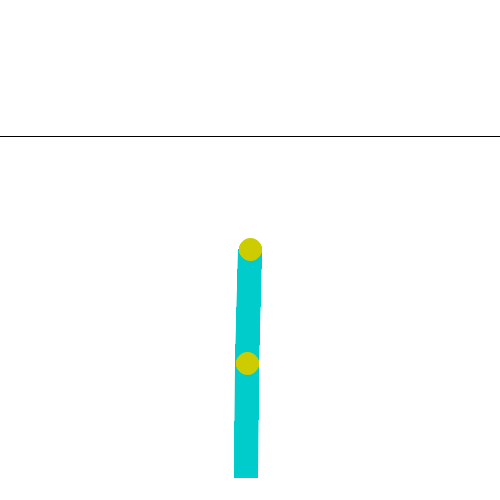

Демонстрация 2:


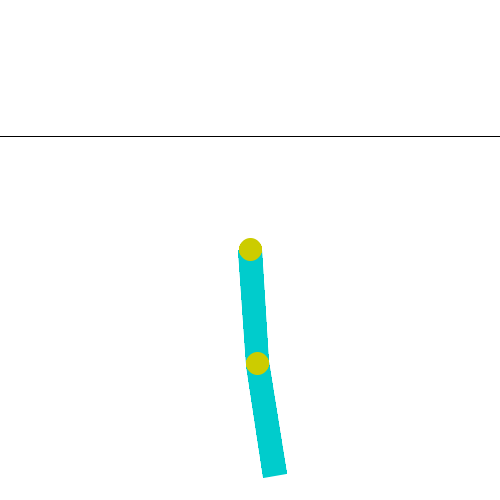

Демонстрация 3:


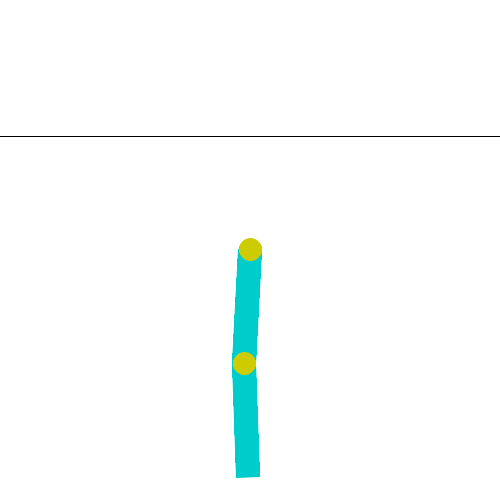

In [9]:
# Показываем сохраненные GIF
for i in range(3):
    gif_path = f'acrobot_demo_{i+1}.gif'
    if os.path.exists(gif_path):
        print(f"Демонстрация {i+1}:")
        display(Image(filename=gif_path))
    else:
        print(f"Файл {gif_path} не найден")